Epoch 1/20, Average Loss: 1.2052


Epoch 2/20, Average Loss: 0.8158


Epoch 3/20, Average Loss: 0.8435


Epoch 4/20, Average Loss: 0.5892


Epoch 5/20, Average Loss: 0.5584


Epoch 6/20, Average Loss: 0.4889


Epoch 7/20, Average Loss: 0.4778


Epoch 8/20, Average Loss: 0.4621


Epoch 9/20, Average Loss: 0.4208


Epoch 10/20, Average Loss: 0.5742


Epoch 11/20, Average Loss: 0.6280


Epoch 12/20, Average Loss: 0.6322


Epoch 13/20, Average Loss: 0.4821


Epoch 14/20, Average Loss: 0.4493


Epoch 15/20, Average Loss: 0.3624


Epoch 16/20, Average Loss: 0.3927


Epoch 17/20, Average Loss: 0.3537


Epoch 18/20, Average Loss: 0.3231


Epoch 19/20, Average Loss: 0.2849


Epoch 20/20, Average Loss: 0.2686


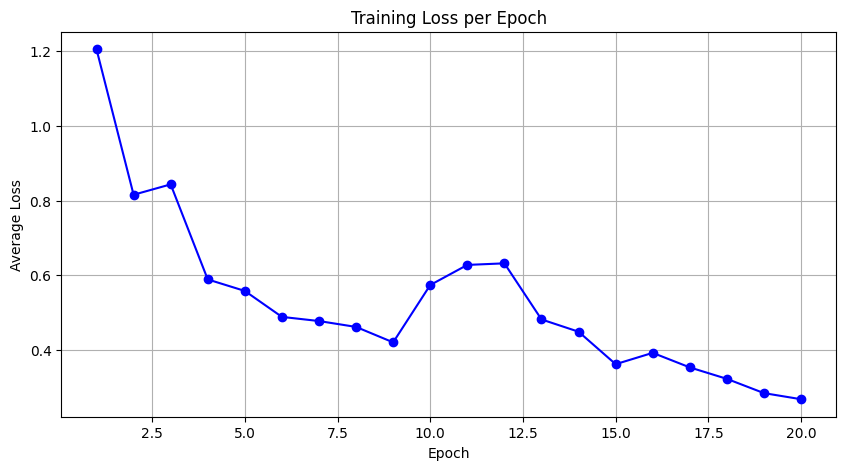

Test Accuracy: 77.78%


In [6]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set random seed and device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the 18 landmarks in the order they appear in your CSV
landmark_order = [
    "Nose", "Neck", "Right Shoulder", "Right Elbow", "Right Wrist",
    "Left Shoulder", "Left Elbow", "Left Wrist", "Right Hip", "Right Knee",
    "Right Ankle", "Left Hip", "Left Knee", "Left Ankle", "Right Eye",
    "Left Eye", "Right Ear", "Left Ear"
]

# Spatial graph edges for 18 joints
edges = [
    (0, 1),   # Nose to Neck
    (1, 2),   # Neck to Right Shoulder
    (2, 3),   # Right Shoulder to Right Elbow
    (3, 4),   # Right Elbow to Right Wrist
    (1, 5),   # Neck to Left Shoulder
    (5, 6),   # Left Shoulder to Left Elbow
    (6, 7),   # Left Elbow to Left Wrist
    (1, 8),   # Neck to Right Hip
    (8, 9),   # Right Hip to Right Knee
    (9, 10),  # Right Knee to Right Ankle
    (1, 11),  # Neck to Left Hip
    (11, 12), # Left Hip to Left Knee
    (12, 13), # Left Knee to Left Ankle
    (0, 14),  # Nose to Right Eye
    (0, 15),  # Nose to Left Eye
    (14, 16), # Right Eye to Right Ear
    (15, 17)  # Left Eye to Left Ear
]

# Function to create adjacency matrix for graph convolution
def create_adjacency_matrix(num_joints, edges):
    A = np.zeros((num_joints, num_joints))
    for edge in edges:
        i, j = edge
        A[i, j] = 1
        A[j, i] = 1  # Undirected graph
    A += np.eye(num_joints)
    D = np.diag(np.sum(A, axis=1) ** -0.5)
    A = D @ A @ D
    return torch.tensor(A, dtype=torch.float32)

# Graph Convolution Layer
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super(GraphConv, self).__init__()
        self.A = A.to(device)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
    
    def forward(self, x):
        batch, channels, time, vertices = x.size()
        x = x.permute(0, 2, 3, 1)
        x = torch.matmul(self.A, x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv(x)
        return x

# ST-GCN Block
class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, temporal_kernel_size=3, stride=1, residual=True):
        super(STGCNBlock, self).__init__()
        self.gcn = GraphConv(in_channels, out_channels, A)
        self.tcn = nn.Conv2d(out_channels, out_channels, kernel_size=(temporal_kernel_size, 1), 
                             padding=(temporal_kernel_size//2, 0), stride=(stride, 1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        
        self.residual = residual
        if residual:
            self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=(stride, 1))
            self.res_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x_gcn = self.gcn(x)
        x_tcn = self.tcn(x_gcn)
        x_tcn = self.bn(x_tcn)
        if self.residual:
            res = self.res_conv(x)
            res = self.res_bn(res)
            x_tcn = x_tcn + res
        x_tcn = self.relu(x_tcn)
        x_tcn = self.dropout(x_tcn)
        return x_tcn

# Enhanced ST-GCN Model
class EnhancedSTGCN(nn.Module):
    def __init__(self, in_channels=3, num_joints=18, num_classes=2, graph_edges=None):
        super(EnhancedSTGCN, self).__init__()
        self.num_joints = num_joints
        self.A = create_adjacency_matrix(num_joints, graph_edges)
        
        self.block1 = STGCNBlock(in_channels, 64, self.A, temporal_kernel_size=3)
        self.block2 = STGCNBlock(64, 64, self.A, temporal_kernel_size=3)
        self.block3 = STGCNBlock(64, 128, self.A, temporal_kernel_size=3, stride=2)
        self.block4 = STGCNBlock(128, 128, self.A, temporal_kernel_size=3)
        self.block5 = STGCNBlock(128, 256, self.A, temporal_kernel_size=3, stride=2)
        self.block6 = STGCNBlock(256, 256, self.A, temporal_kernel_size=3)
        
        self.pool = nn.AdaptiveAvgPool2d((1, num_joints))
        self.fc = nn.Linear(256 * num_joints, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.pool(x)
        x = x.reshape(x.size(0), -1)  # Fixed: Assign reshaped tensor
        x = self.fc(x)
        return x

# Function to process a single CSV file into a skeleton sequence
def process_csv_to_skeleton(csv_path, expected_frames=30, landmarks=18):
    df = pd.read_csv(csv_path)
    # Calculate number of frames
    num_frames = len(df) // landmarks
    if len(df) % landmarks != 0:
        print(f"Warning: CSV {csv_path} has {len(df)} rows, not divisible by {landmarks} landmarks.")
        df = df.iloc[:num_frames * landmarks]
    
    skeleton_sequence = np.zeros((num_frames, landmarks, 3))
    for frame in range(num_frames):
        frame_data = df[df['frame'] == frame]
        if frame_data.empty:
            continue
        for i, landmark in enumerate(landmark_order):
            landmark_data = frame_data[frame_data['landmark'] == landmark]
            if not landmark_data.empty:
                skeleton_sequence[frame, i] = landmark_data[['x', 'y', 'z']].values[0]
    
    # Pad if fewer than expected frames
    if num_frames < expected_frames:
        padding = np.zeros((expected_frames - num_frames, landmarks, 3))
        skeleton_sequence = np.vstack((skeleton_sequence, padding))
    elif num_frames > expected_frames:
        skeleton_sequence = skeleton_sequence[:expected_frames]
    
    assert skeleton_sequence.shape == (expected_frames, landmarks, 3), f"Unexpected shape: {skeleton_sequence.shape} for {csv_path}"
    return skeleton_sequence

# Dataset Class
class FallDataset(Dataset):
    def __init__(self, fall_dir, no_fall_dir, expected_frames=30, landmarks=18):
        self.data = []
        self.labels = []
        self.expected_frames = expected_frames
        self.landmarks = landmarks
        
        for root, _, files in os.walk(fall_dir):
            for csv_file in files:
                if csv_file.endswith(".csv"):
                    csv_path = os.path.join(root, csv_file)
                    skeleton = process_csv_to_skeleton(csv_path, expected_frames, landmarks)
                    self.data.append(skeleton)
                    self.labels.append(1)
        
        for root, _, files in os.walk(no_fall_dir):
            for csv_file in files:
                if csv_file.endswith(".csv"):
                    csv_path = os.path.join(root, csv_file)
                    skeleton = process_csv_to_skeleton(csv_path, expected_frames, landmarks)
                    self.data.append(skeleton)
                    self.labels.append(0)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        skeleton = torch.tensor(self.data[idx], dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return skeleton, label

def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix({'batch_loss': f'{loss.item():.4f}'})
        
        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Main Execution
if __name__ == "__main__":
    fall_dir = "processed/fall/csv"
    no_fall_dir = "processed/nofall/csv"
    
    dataset = FallDataset(fall_dir, no_fall_dir, expected_frames=30, landmarks=18)
    train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    test_dataset = torch.utils.data.Subset(dataset, test_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    model = EnhancedSTGCN(in_channels=3, num_joints=18, num_classes=2, graph_edges=edges).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_model(model, train_loader, criterion, optimizer, num_epochs=20)
    evaluate_model(model, test_loader)
    
    torch.save(model.state_dict(), "Models/enhanced_stgcn_fall_detection.pth")